In [1]:
import numpy as np 
import math 
import glob 
import pandas as pd
import scipy.io
import json 
import matplotlib.pyplot as plt
import h5py
import os


/var/folders/v8/zmb9hj_97tjcq8mb570v8wq40000gp/T/ipykernel_3570/2551969211.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
subject = 'sub-01'
task = 'SacLoc'
ses = 'ses-01'

In [3]:
def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)

def ensure_save_dir(base_dir, subject):
    save_dir = f"{base_dir}/{subject}/eyetracking"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    return save_dir

In [30]:
def plotly_layout_template(task,run):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import numpy as np

    # Horizontal eye trace
    screen_val =  12.5
    ymin1,ymax1,y_tick_num1 = -screen_val,screen_val,11
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    xmin1,xmax1,x_tick_num1 = 0,1,5
    x_tick1 = np.linspace(xmin1,xmax1,x_tick_num1)

    # Vertical eye trace
    ymin2,ymax2,y_tick_num2 = -screen_val,screen_val,11
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    xmin2,xmax2,x_tick_num2 = 0,1,5
    x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)

    analysis_info = {'rads': [0,2.5,5,7.5,10,0]}  
    theta = np.linspace(0, 2*np.pi, 100)

    # Constants
    axis_width = 1

    # Create subplots with modified layout
    fig = make_subplots(
        rows=2, cols=3,
        column_widths=[0.5, 0.5, 0],
        horizontal_spacing = 0.1,
        specs=[[{}, {"rowspan": 2},{'type': 'polar'}],
            [{}, None, None]]
    )

    # Plot horizontal eye position
    for rad in analysis_info['rads']:
        fig.add_trace(
            go.Scatter(x=x_tick1, y=x_tick1*0+rad, mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=x_tick1, y=x_tick1*0-rad, mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=1, col=1
        )

    # Plot vertical eye position
    for rad in analysis_info['rads']:
        fig.add_trace(
            go.Scatter(x=x_tick2, y=x_tick2*0+rad, mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=x_tick2, y=x_tick2*0-rad, mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=2, col=1
        )

    fig.add_vrect(x0=0, x1=1, row="all", col=1,
                fillcolor="grey", opacity=0.15, line_width=0)

    # Plot screen view
    for rad in analysis_info['rads']:
        fig.add_trace(
            go.Scatter(x=rad*np.cos(theta), y=rad*np.sin(theta), mode='lines', line=dict(color='black', width=axis_width*0.5)),
            row=1, col=2
        )

    fig.add_vrect(x0=-12.5, x1=12.5, row="all", col=2,
                fillcolor="grey", opacity=0.15, line_width=0)

    # Update layout
    y_data = [-12.5,-10.0,-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5,10.0,12.5]
    fig.update_xaxes(title_text="Time (%)", row=1, col=1)
    fig.update_xaxes(title_text="Time (%)", row=2, col=1)
    fig.update_yaxes(title_text="Hor. coord. (dva)",tickvals=y_data, range = [-12.5,12.5], row=1, col=1, title_standoff=0.15)
    fig.update_yaxes(title_text="Ver. coord. (dva)",tickvals=y_data, range = [-12.5,12.5],row=2, col=1, title_standoff=0.15),


    fig.update_xaxes(title_text="Horizontal coordinates (dva)", tickvals=y_data,range = [-12.5,12.5], row=1, col=2)
    fig.update_yaxes(title_text="Vertical coordinates (dva)", tickvals=y_data,range = [-12.5,12.5], row=1, col=2, title_standoff=0.15)



    fig.update_layout(
        showlegend=False,
        title=f"Eye Positions {task}, run {run + 1}",
        height=700,
        width=1420,  
        template="simple_white", 
        margin=dict(
            l=100,
            r=10,
            b=100,
            t=100
        )
    )


    return fig 


In [4]:
# data paths
if subject == 'sub-01': 
    data_mat = sorted(glob.glob(r'/Users/sinakling/projects/PredictEye/locEMexp/data/{}/ses-01/add/*.mat'.format(subject)))
    matfile = scipy.io.loadmat(data_mat[0])

    data_events = sorted(glob.glob(r'/Users/sinakling/projects/PredictEye/locEMexp/data/{}/ses-01/func/*.tsv'.format(subject)))
    data_events = data_events[:2]

else: 
    data_mat = sorted(glob.glob(r'/Users/sinakling/projects/PredictEye/locEMexp/data/{}/ses-02/add/*.mat'.format(subject)))
    matfile = scipy.io.loadmat(data_mat[0])

    data_events = sorted(glob.glob(r'/Users/sinakling/projects/PredictEye/locEMexp/data/{}/ses-02/func/*.tsv'.format(subject)))
    data_events = data_events[:2]


In [5]:
# extract event files 
num_run = len(data_events)
dfs_runs = []

# Read each TSV file 
for i, run in enumerate(data_events):
    df_run = pd.read_csv(run, sep="\t")
    dfs_runs.append(df_run)

In [8]:
trial_durations = dfs_runs[0]['duration']*1000
run_durations = np.cumsum(trial_durations)

trial_durations_2 = dfs_runs[1]['duration']*1000
run_durations_2 = np.cumsum(trial_durations_2)


In [6]:
# load data
with open('/Users/sinakling/projects/pRF_analysis/RetinoMaps/eyetracking/dev/PurLoc_SacLoc/behavior_settings.json') as f:
		json_s = f.read()
		analysis_info = json.loads(json_s)


main_dir = analysis_info['main_dir_mac']
file_dir_save = ensure_save_dir(f'{main_dir}/derivatives/pp_data', subject)

h5_filename = f'{file_dir_save}/stats/{subject}_task-{task}_eyedata_sac_stats.h5'
h5_file = h5py.File(h5_filename,'r')
time_start_trial = np.array(h5_file['time_start_trial'])
time_end_trial = np.array(h5_file['time_end_trial'])
time_start_seq = np.array(h5_file['time_start_seq'])
time_end_seq = np.array(h5_file['time_end_seq'])
time_start_eye = np.array(h5_file['time_start_eye'])
time_end_eye = np.array(h5_file['time_end_eye'])



In [7]:
eye_data_run_01_nan_blink_interpol = pd.read_csv(f"{file_dir_save}/timeseries/{subject}_task-{task}_run_01_eyedata.tsv.gz", compression='gzip', delimiter='\t')
eye_data_run_01_nan_blink_interpol = eye_data_run_01_nan_blink_interpol[['timestamp', 'x', 'y', 'pupil_size']].to_numpy()
eye_data_run_02_nan_blink_interpol = pd.read_csv(f"{file_dir_save}/timeseries/{subject}_task-{task}_run_02_eyedata.tsv.gz", compression='gzip', delimiter='\t')
eye_data_run_02_nan_blink_interpol = eye_data_run_02_nan_blink_interpol[['timestamp', 'x', 'y', 'pupil_size']].to_numpy()

eye_data_all_runs = [eye_data_run_01_nan_blink_interpol,eye_data_run_02_nan_blink_interpol]

In [8]:
# Generate Expected Position 
# extract fixation point position 

# in screen coordinates
# in trial length 

saccade_coord_x = matfile['config']['const'][0,0]['pursuit_matX'][0][0][0] # (4,32) = amp, dir
saccade_coord_y = matfile['config']['const'][0,0]['pursuit_matY'][0][0][0]


amplitude = list(df_run['eyemov_amplitude'])
seq_trial = list(df_run['sequence_trial'])

sac_expected_x = []
sac_expected_y = []

for amp, trial in zip(amplitude, seq_trial):
    if amp == 5: 
        x_coord = 960.0
    else: 
        x_coord = saccade_coord_x[amp-1, trial-1]
    sac_expected_x.append(x_coord)


expected_y = []

for amp, trial in zip(amplitude, seq_trial):
    if amp == 5: 
        y_coord = 540.0
    else: 
        y_coord = saccade_coord_y[amp-1, trial-1]
    sac_expected_y.append(y_coord)

# convert to dva 
sac_expected_x = (np.array(sac_expected_x) - (analysis_info['center'][0]))/analysis_info['ppd']
sac_expected_y =  -1.0*((np.array(sac_expected_y) - (analysis_info['center'][1]))/analysis_info['ppd'])

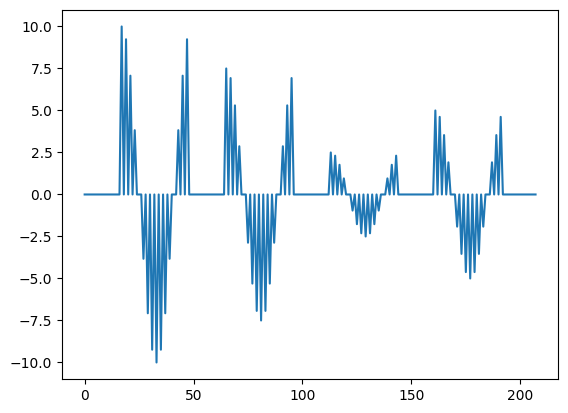

In [37]:
plt.plot(sac_expected_x)

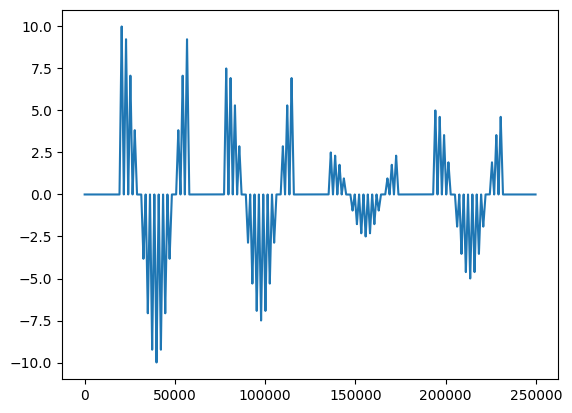

In [39]:
sac_x_test = interp1d(sac_expected_x, new_len=int(249760)) 
sac_y_test = interp1d(sac_expected_y, new_len=int(249760)) 

plt.plot(sac_x_test)

In [28]:
import numpy as np
from scipy.signal import resample

fs_eye_tracking = 1000

# Assume sac_expected_x is your original target position array and you want to resample it
total_duration_trials = time_end_trial[15,8,0] - time_start_trial[0,0,0]
print(total_duration_trials)

# Number of samples in your eye-tracking data during this period
num_eye_tracking_samples = int(total_duration_trials) + 1 # fs_eye_tracking is in Hz
print(num_eye_tracking_samples)


# Resample sac_expected_x to match the eye-tracking data length
sac_x_expected_resampled = resample(sac_expected_x, num_eye_tracking_samples)
sac_y_expected_resampled = resample(sac_expected_y, num_eye_tracking_samples)

# Now sac_expected_resampled should be aligned with your eye-tracking data in terms of sample size


249759.0
249760


In [26]:
#! OLD (use resampling instead)
trials_seq = analysis_info['trials_seq']

full_prediction = []
gaps = []
trials = []
# Loop through sequences
for seq in range(9):
    # Get the number of trials for the current sequence
    num_trials_in_seq = trials_seq[seq]

    # Loop through the trials in the current sequence
    for trial in range(num_trials_in_seq):
        
        # Duration of the current trial
        trial_duration = time_end_trial[trial, seq, 0] - time_start_trial[trial, seq, 0]
        trials.append(trial_duration)
        
        # Append the target position for the entire trial duration
        full_prediction.extend([sac_expected_y[trial]] * int(trial_duration))
        
        # Only calculate gaps if it's NOT the last trial in the sequence
        if trial < num_trials_in_seq - 1:
            gap_duration = time_start_trial[trial + 1, seq, 0] - time_end_trial[trial, seq, 0]
            gaps.append(gap_duration)
            full_prediction.extend([sac_expected_y[trial]] * int(gap_duration))


In [26]:
def extract_data(main_dir, subject, task, runs):
    '''read tsv.gsv data as pandas dataframes. Use information from json as columns'''
    df_runs = []
    for run in range(runs):
        tsv_file_path = f"{file_dir_save}/timeseries/{subject}_task-{task}_run_0{run + 1}_eyedata.tsv.gz"
      

        df = pd.read_csv(
            tsv_file_path, 
            compression='gzip', 
            delimiter='\t', 
            na_values='n/a'  # Treat 'n/a' as NaN
        )

        df_runs.append(df)

    return df_runs


df_sep_runs = extract_data(main_dir, subject, task, num_run)

In [ ]:
# Expected Position 
# extract pursuit point position 

pursuit_coord_x = matfile['config']['const'][0,0]['pursuit_matX'][0][0][0]
pursuit_coord_y = matfile['config']['const'][0,0]['pursuit_matY'][0][0][0]

amplitude = list(df_run['eyemov_amplitude'])
seq_trial = list(df_run['sequence_trial'])

purs_expected_x = []


for amp, trial in zip(amplitude, seq_trial):
    if amp == 5: 
        x_coord = 960.0
    else: 
        x_coord = pursuit_coord_x[amp-1, trial-1]
    purs_expected_x.append(x_coord)


purs_expected_y = []

for amp, trial in zip(amplitude, seq_trial):
    if amp == 5: 
        y_coord = 540.0
    else: 
        y_coord = pursuit_coord_y[amp-1, trial-1]
    purs_expected_y.append(y_coord)
    


# Convert to dva 
purs_expected_x = (np.array(purs_expected_x) - (analysis_info['center']))/analysis_info['ppd']
purs_expected_y =  -1.0*((np.array(purs_expected_y) - (analysis_info['center']))/analysis_info['ppd'])


purs_x_intpl_run_1 = interp1d(purs_expected_x, new_len=int(248800)) # align with length of 1 run 
purs_y_intpl_run_1 = interp1d(purs_expected_y, new_len=int(248800))  # align with length of 1 run 

purs_x_intpl_run_2 = interp1d(purs_expected_x, new_len=int(248800)) # align with length of 1 run 
purs_y_intpl_run_2 = interp1d(purs_expected_y, new_len=int(248800))  # align with length of 1 run 


In [ ]:
# demonstration of sequence principle

for amp, trial in zip(amplitude, seq_trial):
    if amp != 5:
        plt.scatter(pursuit_coord_x[amp -1 , trial -1 ], pursuit_coord_y[amp - 1, trial - 1])
        plt.gca().invert_yaxis()

plt.show()

In [29]:
# Generate Expected Position 
# extract fixation point position 

# in screen coordinates
# in trial length 

saccade_coord_x = matfile['config']['const'][0,0]['pursuit_matX'][0][0][0] # (4,32) = amp, dir
saccade_coord_y = matfile['config']['const'][0,0]['pursuit_matY'][0][0][0]


amplitude = list(df_run['eyemov_amplitude'])
seq_trial = list(df_run['sequence_trial'])

sac_expected_x = []
sac_expected_y = []

for amp, trial in zip(amplitude, seq_trial):
    if amp == 5: 
        x_coord = 960.0
    else: 
        x_coord = saccade_coord_x[amp-1, trial-1]
    sac_expected_x.append(x_coord)


expected_y = []

for amp, trial in zip(amplitude, seq_trial):
    if amp == 5: 
        y_coord = 540.0
    else: 
        y_coord = saccade_coord_y[amp-1, trial-1]
    sac_expected_y.append(y_coord)

# convert to dva 
sac_expected_x = (np.array(sac_expected_x) - (analysis_info['center'][0]))/analysis_info['ppd']
sac_expected_y =  -1.0*((np.array(sac_expected_y) - (analysis_info['center'][1]))/analysis_info['ppd'])

In [27]:
import numpy as np

def calculate_corresponding_indices(array1, array2, slice_indices_1):
    L1 = len(array1)
    L2 = len(array2)

    # Initialize an empty list to store the corresponding indices for array2
    corresponding_indices_2 = []

    for index in slice_indices_1:
        # Calculate the corresponding index for array2 using the proportional mapping
        index_2 = round((index / L1) * L2)
        corresponding_indices_2.append(index_2)

    return corresponding_indices_2

# Slice indices for array1
slice_indices_1 = [19146, 58560, 76472, 115847,133751, 173157,191079, 230470]

# Calculate corresponding indices for array
resulting_indices_2 = calculate_corresponding_indices(eye_data_run_01_nan_blink_interpol[:len(df_sep_runs[0]),1], sac_expected_x_run, slice_indices_1)

# Output the results
print(f"Eyetracking slice indices: {slice_indices_1}")
print(f"Corresponding Prediction indices: {resulting_indices_2}")


Eyetracking slice indices: [19146, 58560, 76472, 115847, 133751, 173157, 191079, 230470]
Corresponding Prediction indices: [19010, 58143, 75928, 115022, 132799, 171924, 189719, 228829]


In [ ]:
# plot moving sequences 
import plotly.graph_objects as go

eye_data_run_1_x = eye_data_run_01_nan_blink_interpol[:,1]
eye_data_run_1_y = eye_data_run_01_nan_blink_interpol[:,2]

# Define the start and end indices for each slice
slice_indices_mov_seq = [(int(run_durations[i]), int(run_durations[i+33])) for i in range(15, 161, 48)]

# Plot each slice individually
for start, end in slice_indices_mov_seq:
    fig = plotly_layout_template("PurLoc",0)

    fig.add_trace(go.Scatter(y = eye_data_run_1_x[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = purs_x_intpl_run_1[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = eye_data_run_1_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(y = purs_y_intpl_run_1[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = eye_data_run_1_x[start:end], y = eye_data_run_1_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 2)
    fig.add_trace(go.Scatter(x = purs_x_intpl_run_1[start:end], y = purs_y_intpl_run_1[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 1, col = 2)


    fig.show()

    fig_fn = f"pursuit_pred_test.pdf"
    print('Saving {}'.format(fig_fn))
    fig.write_image(fig_fn)

In [ ]:
import plotly.graph_objects as go

eye_data_run_2_x = eye_data_run_02_nan_blink_interpol [len(df_sep_runs[0]):]
eye_data_run_2_y = eye_data_run_02_nan_blink_interpol [len(df_sep_runs[0]):]

# Define the start and end indices for each slice
slice_indices = [(int(run_durations_2[i]), int(run_durations_2[i+33])) for i in range(15, 162, 48)]


# Plot each slice individually
for start, end in slice_indices:
    fig = plotly_layout_template("PurLoc",1)

    fig.add_trace(go.Scatter(y = eye_data_run_2_x[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = purs_x_intpl_run_2[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = eye_data_run_2_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(y = purs_y_intpl_run_2[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = eye_data_run_2_x[start:end], y = eye_data_run_2_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 2)
    fig.add_trace(go.Scatter(x = purs_x_intpl_run_2[start:end], y = purs_y_intpl_run_2[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 1, col = 2)


    fig.show()

In [ ]:
import plotly.graph_objects as go
eye_mov_seq = analysis_info['eye_mov_seq']
eye_mov_seq = [1,2, 3,4,5,6,7,8]

for sequence in eye_mov_seq:
    seq_eye_data_logic = np.logical_and(eye_data_run_01_nan_blink_interpol[:,0] >= time_start_seq[sequence,0],\
                                        eye_data_run_01_nan_blink_interpol[:,0] <= time_end_seq[sequence,0])
    
    fig = plotly_layout_template("SacLoc",0)

    fig.add_trace(go.Scatter(y = eye_data_run_01_nan_blink_interpol[seq_eye_data_logic][:,1],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = sac_x_test[seq_eye_data_logic],showlegend=False,line=dict(color='green', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = eye_data_run_01_nan_blink_interpol[seq_eye_data_logic][:,2],showlegend=False,line=dict(color='black', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(y = sac_y_test[seq_eye_data_logic],showlegend=False,line=dict(color='green', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = eye_data_run_01_nan_blink_interpol[seq_eye_data_logic][:,1], y = eye_data_run_01_nan_blink_interpol[seq_eye_data_logic][:,2],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 2)
    fig.add_trace(go.Scatter(x = sac_x_test[seq_eye_data_logic], y = sac_y_test[seq_eye_data_logic],showlegend=False,line=dict(color='green', width=2)), row = 1, col = 2)

    fig.show()


In [ ]:
import plotly.graph_objects as go

eye_data_run_1_x = eye_data_run_01_nan_blink_interpol[:,1]
eye_data_run_1_y = eye_data_run_01_nan_blink_interpol[:,2]

# Define the start and end indices for each slice
slice_indices = [(int(run_durations[i]), int(run_durations[i+33])) for i in range(15, 161, 48)]
slice_indices_exp = [(19695, 58860), (76650, 115847), (133651, 172974), (190490, 230070)]  # accomodating for different length of prediction 

# Plot each slice individually
for (start_eye, end_eye), (start_exp, end_exp) in zip(slice_indices, slice_indices_exp):
    fig = plotly_layout_template("SacLoc",0)

    fig.add_trace(go.Scatter(y = eye_data_run_1_x[start_eye:end_eye],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = sac_expected_x_run[start_exp:end_exp],showlegend=False,line=dict(color='green', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = eye_data_run_1_y[start_eye:end_eye],showlegend=False,line=dict(color='black', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(y = sac_expected_y_run[start_exp:end_exp],showlegend=False,line=dict(color='green', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = eye_data_run_1_x[start_eye:end_eye], y = eye_data_run_1_y[start_eye:end_eye],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 2)
    fig.add_trace(go.Scatter(x = sac_expected_x_run[start_exp:end_exp], y = sac_expected_y_run[start_exp:end_exp],showlegend=False,line=dict(color='green', width=2)), row = 1, col = 2)

    fig.show()

In [ ]:
import plotly.graph_objects as go

eye_data_run_1_x = eyetracking_data_all_runs_x_intpol[:len(df_sep_runs[0])]
eye_data_run_1_y = eyetracking_data_all_runs_y_intpol[:len(df_sep_runs[0])]

# Define the start and end indices for each slice
slice_indices_fix_seq = [(int(run_durations[i]), int(run_durations[i+15])) for i in range(0, 192, 48)]

# Plot each slice individually
for start, end in slice_indices_fix_seq:
    fig = plotly_layout_template("SacLoc",0)

    fig.add_trace(go.Scatter(y = eye_data_run_1_x[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = sac_expected_x_run[start:end],showlegend=False,line=dict(color='green', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = eye_data_run_1_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(y = sac_expected_y_run[start:end],showlegend=False,line=dict(color='green', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = eye_data_run_1_x[start:end], y = eye_data_run_1_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 2)
    fig.add_trace(go.Scatter(x = sac_expected_x_run[start:end], y = sac_expected_y_run[start:end],showlegend=False,line=dict(color='green', width=2)), row = 1, col = 2)

    fig.show()

In [ ]:
# plot fixation sequences

eye_data_run_1_x = eyetracking_data_all_runs_x_intpol[:len(df_sep_runs[0])]
eye_data_run_1_y = eyetracking_data_all_runs_y_intpol[:len(df_sep_runs[0])]

# Define the start and end indices for each slice
slice_indices_fix_seq = [(int(run_durations[i]), int(run_durations[i+15])) for i in range(0, 192, 48)]

# Plot each slice individually
for start, end in slice_indices_fix_seq:
    fig = plotly_layout_template("PurLoc",0)

    fig.add_trace(go.Scatter(y = eye_data_run_1_x[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = purs_x_intpl_run_1[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = eye_data_run_1_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(y = purs_y_intpl_run_1[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = eye_data_run_1_x[start:end], y = eye_data_run_1_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 2)
    fig.add_trace(go.Scatter(x = purs_x_intpl_run_1[start:end], y = purs_y_intpl_run_1[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 1, col = 2)


    fig.show()

In [ ]:
# plot fixation sequences

eye_data_run_2_x = eyetracking_data_all_runs_x_intpol[len(df_sep_runs[0]):]
eye_data_run_2_y = eyetracking_data_all_runs_y_intpol[len(df_sep_runs[0]):]

# Define the start and end indices for each slice
slice_indices_fix_seq = [(int(run_durations_2[i]), int(run_durations_2[i+15])) for i in range(0, 192, 48)]

# Plot each slice individually
for start, end in slice_indices_fix_seq:
    fig = plotly_layout_template("PurLoc",1)

    fig.add_trace(go.Scatter(y = eye_data_run_2_x[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = purs_x_intpl_run_2[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 1, col = 1)
    fig.add_trace(go.Scatter(y = eye_data_run_2_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(y = purs_y_intpl_run_2[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = eye_data_run_2_x[start:end], y = eye_data_run_2_y[start:end],showlegend=False,line=dict(color='black', width=2)), row = 1, col = 2)
    fig.add_trace(go.Scatter(x = purs_x_intpl_run_2[start:end], y = purs_y_intpl_run_2[start:end],showlegend=False,line=dict(color='blue', width=2)), row = 1, col = 2)


    fig.show()

In [ ]:
# Eucledian Distance 
fig = plt.figure(figsize=(20, 10))

#median_gaze = np.nanmedian(eye_data[:int(run_durations[207]), 1:3], axis=0)
eucl_dist = np.sqrt((eyetracking_data_all_runs_x_intpol[:len(purs_x_intpl_run_1)] - purs_x_intpl_run_1)**2 + ( eyetracking_data_all_runs_y_intpol[:len(purs_y_intpl_run_1)]- purs_y_intpl_run_1)**2)
#eucl_dist_2 = np.sqrt((- purs_x_intpl_run_2)**2 + ( - purs_y_intpl_run_2)**2)

plt.plot(eucl_dist)
#plt.plot(eucl_dist_2)

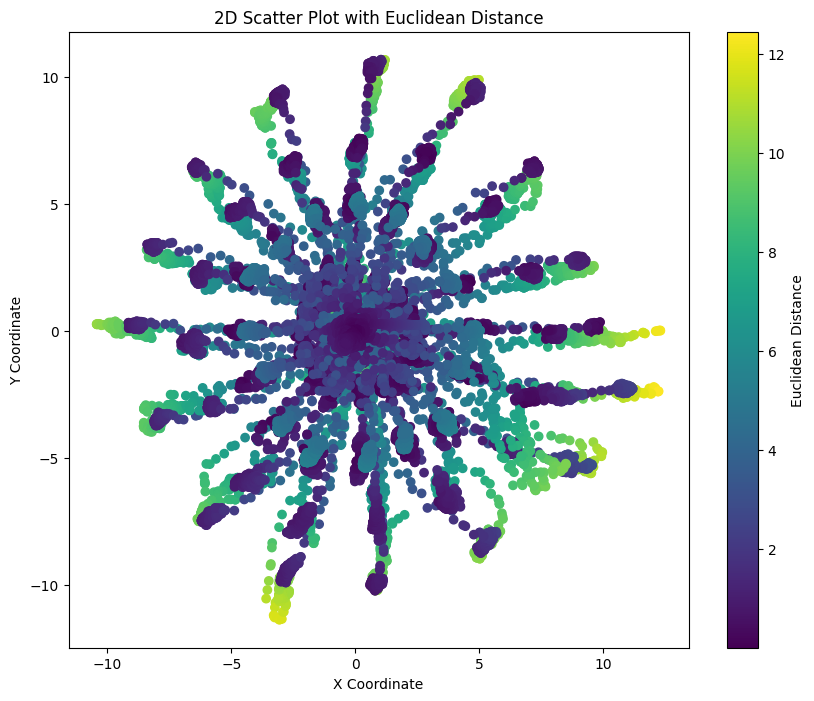

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Example setup (assuming you have the necessary data)
x1 = eye_data_run_01_nan_blink_interpol[:len(sac_expected_x_run),1]
y1 = eye_data_run_01_nan_blink_interpol[:len(sac_expected_y_run),2]
x2 = sac_expected_x_run
y2 = sac_expected_y_run

# Compute Euclidean distance
eucl_dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Create scatter plot with color coding for the distance
plt.figure(figsize=(10, 8))
sc = plt.scatter(x1, y1, c=eucl_dist, cmap='viridis', marker='o')

# Adding colorbar to show magnitude of distance
plt.colorbar(sc, label="Euclidean Distance")

# Labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Scatter Plot with Euclidean Distance')

plt.show()


In [ ]:
# Eucledian Distance SacLoc
fig = plt.figure(figsize=(20, 10))

#median_gaze = np.nanmedian(eye_data[:int(run_durations[207]), 1:3], axis=0)
eucl_dist_sac = np.sqrt((eye_data_run_01_nan_blink_interpol[:len(sac_expected_x_run),1] - sac_expected_x_run)**2 + (eye_data_run_01_nan_blink_interpol[:len(sac_expected_y_run),2]- sac_expected_y_run)**2)
#eucl_dist_2 = np.sqrt((- purs_x_intpl_run_2)**2 + ( - purs_y_intpl_run_2)**2)

plt.plot(eucl_dist_sac)
#plt.plot(eucl_dist_2)

In [376]:
thresholds = [0.5, 1.0, 1.5, 2.0]  # TODO: Make continuous linspace
precision = []

for thr in thresholds: 
    count = np.sum(eucl_dist < thr)
    fraction = count / len(purs_x_intpl_run_1) 
    precision.append(fraction)

np.save("precision_run_1_x_sub_04",np.array(precision))

In [378]:
precision_sub_1 = np.load("precision_run_1_x_sub_01.npy")
precision_sub_2 = np.load("precision_run_1_x_sub_02.npy")
#precision_sub_4 = np.load("precision_run_1_x_sub_04.npy")
precision_sub_3 = np.load("precision_run_1_x_sub_03.npy")
precision_sub_5 = np.load("precision_run_1_x_sub_05.npy")
precision_sub_7 = np.load("precision_run_1_x_sub_07.npy")
precision_sub_11 = np.load("precision_run_1_x_sub_11.npy")


In [379]:
import plotly.graph_objs as go
import numpy as np

# Example data for each subject (replace with your actual data)
subject_data = {
    1: precision_sub_1,
    2: precision_sub_2,
    3: precision_sub_3,
    4: precision, 
    5: precision_sub_5,
    7: precision_sub_7,
    11: precision_sub_11
    
}

# Define colors for the subjects
colors = ['blue', 'cyan', 'green', 'lightgreen','red','darkred','brown'] #

# Create traces for each subject
traces = []
for subject, color in zip(subject_data.keys(), colors):
    traces.append(go.Scatter(
        y=subject_data[subject],
        mode='lines',
        name=f'Subject {subject}',
        line=dict(color=color)
    ))

# Create the plot layout with a simple white background and square figure
layout = go.Layout(
    title="Threshold vs Below Threshold (%)",
    xaxis=dict(
        title='Threshold (°)',
        range=[0, 2],
        zeroline=True,       # Add x-axis zero line
        linecolor='black',   # Black color for the x-axis line
        showgrid=False       # Remove grid lines
    ),
    yaxis=dict(
        title='Below threshold (%)',
        range=[0, 1],
        zeroline=True,       # Add y-axis zero line
        linecolor='black',   # Black color for the y-axis line
        showgrid=False       # Remove grid lines
    ),
    plot_bgcolor='white',  # Set the background to white
    paper_bgcolor='white',  # Set the paper background to white
    shapes=[  # Vertical line at threshold 1°
        dict(
            type="line",
            x0=1,
            x1=1,
            y0=0,
            y1=1,
            line=dict(color="black", dash="dash")
        )
    ],
    font=dict(family="Arial", size=12, color="black"),  # Clean font style
    height=600,  # Height of the figure (you can adjust this)
    width=700    # Width of the figure (set to be the same as height)
)


# Create the figure and show it
fig = go.Figure(data=traces, layout=layout)
fig.show()


In [387]:
threshold_1 = [precision_sub_1[1], precision_sub_2[1], precision_sub_3[1],precision[1], precision_sub_5[1], precision_sub_7[1], precision_sub_11[1]]
fig = go.Figure(data=go.Scatter(y = threshold_1, mode='markers'))
fig.update_xaxes(title_text="1°")
fig.update_yaxes(range = [0,1])
   


fig.update_layout(
    showlegend=False,
    height=700,
    width=400,  
    template="simple_white"
    
)


fig.show()

In [29]:
# Percentage of valid samples in run(s) (ratio of NaNs after removing blinks to total amount of data points)

valid_samples = np.sum(np.isnan(eye_data[:, 1:3]).any(axis=1))
total_samples = eye_data.shape[0]
valid_ratio = 100 * (1 - valid_samples / total_samples)

print(valid_ratio)

#NSD paper: if ration of valid samples is below 33 %, data is not used 

97.64712504573471
